In [2]:
import numpy as np 
def low_elevation_delay_model(elevation_angle, met_data, freq):
    """
    小仰角大气延迟模型
    
    参数:
    elevation_angle: 仰角(度，≤10°)
    met_data: 气象数据
    freq: 观测频率(GHz)
    """
    # 1. 改进的投影函数
    def improved_mapping_function(elev):
        # 使用更精确的NMF(Niell Mapping Function)或VMF(Vienna Mapping Function)
        a = 0.0012769
        b = 0.0029024
        c = 0.0062106
        
        sin_elev = np.sin(np.radians(elev))
        return (1 + a/(1 + b/(1 + c)))/(sin_elev + a/(sin_elev + b/(sin_elev + c)))
    
    # 2. 考虑大气弯曲效应
    def ray_bending_correction(elev):
        # 射线弯曲修正
        return 0.0031 * np.tan(np.radians(90 - elev))
    
    # 3. 计算基本延迟
    zenith_delay = calculate_zenith_delay(met_data)
    mapping = improved_mapping_function(elevation_angle)
    bending = ray_bending_correction(elevation_angle)
    
    # 4. 添加额外修正项
    total_delay = zenith_delay * mapping + bending
    
    return total_delay

def atmospheric_layers():
    """
    定义大气层结构，返回高度、压强、温度和湿度数据
    返回: (heights, pressures, temperatures, humidities)
    """
    # 定义高度层（从地面到10km，每100m一层）
    heights = np.arange(0, 10000, 100)  # 米
    
    # 初始条件
    T0 = 288.15  # 地面温度(K)
    P0 = 1013.25  # 地面气压(hPa)
    H0 = 0.7  # 地面相对湿度
    
    # 使用标准大气模型计算各层参数
    temperatures = T0 - 0.0065 * heights  # 温度随高度变化
    pressures = P0 * np.exp(-0.0342 * heights/1000)  # 气压随高度变化
    humidities = H0 * np.exp(-heights/2000)  # 湿度随高度指数衰减
    
    return heights, pressures, temperatures, humidities

def calculate_zenith_delay(met_data):
    """计算天顶延迟的改进版本"""
    # 1. 分层大气模型
    heights, pressures, temperatures, humidities = atmospheric_layers()
    
    # 2. 考虑温度梯度
    def temperature_gradient(height):
        T0 = met_data['surface_temperature']
        lapse_rate = -0.0065  # K/m
        return T0 + lapse_rate * height
    
    # 3. 考虑压力变化
    def pressure_profile(height):
        P0 = met_data['surface_pressure']
        return P0 * np.exp(-0.0342 * height)
    
    # 积分计算总延迟
    total_delay = 0
    for i in range(len(heights)):
        T = temperature_gradient(heights[i])
        P = pressure_profile(heights[i])
        # 简化的延迟计算公式
        layer_delay = 77.6 * (P / T) * 0.1  # 0.1是层厚度(100m)转换为km
        total_delay += layer_delay
    
    return total_delay
def evaluate_model_performance():
    """评估模型性能"""
    # 测试案例
    test_conditions = [
        {'elevation': 8, 'temperature': 288.15, 'pressure': 1013.25},
        {'elevation': 5, 'temperature': 288.15, 'pressure': 1013.25},
        {'elevation': 3, 'temperature': 288.15, 'pressure': 1013.25}
    ]
    
    for condition in test_conditions:
        delay = low_elevation_delay_model(
            condition['elevation'],
            {'surface_temperature': condition['temperature'],'surface_pressure': condition['pressure']},
            20  # GHz
        )
        print(f"仰角 {condition['elevation']}°: 延迟 = {delay:.3f} ns")
        
if __name__ == "__main__":
    evaluate_model_performance()

仰角 8°: 延迟 = 191.929 ns
仰角 5°: 延迟 = 288.415 ns
仰角 3°: 延迟 = 435.546 ns


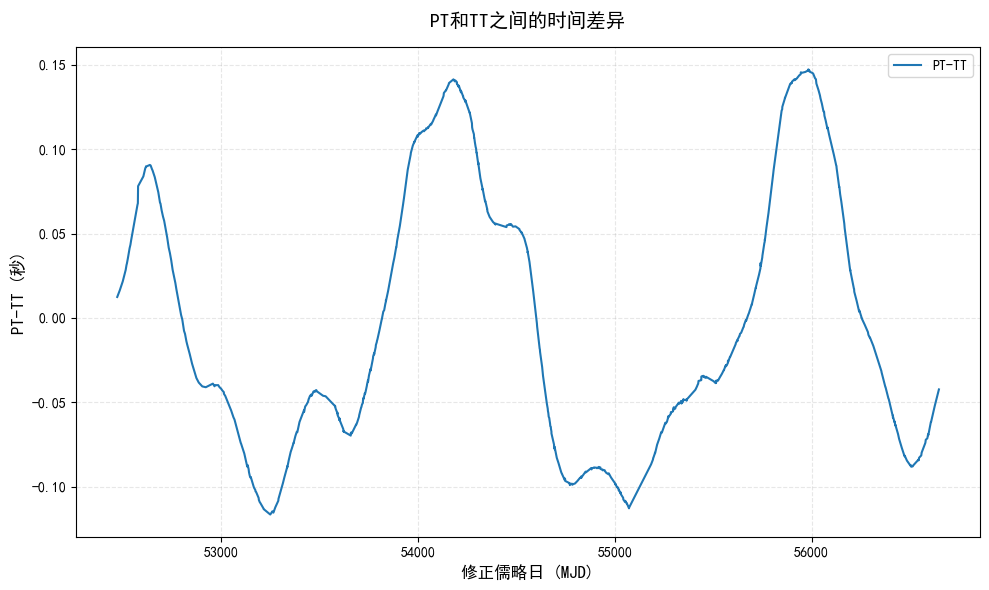

In [15]:

# ——————————————————————————
# 第一部分：原始数据可视化
# ——————————————————————————

# 创建数据可视化图表
plt.figure(figsize=(10, 6), facecolor='white')
plt.plot(time, residuals, label='PT-TT', color='#1f77b4', linewidth=1.5)
plt.xlabel('修正儒略日 (MJD)', fontsize=12)
plt.ylabel('PT-TT (秒)', fontsize=12)
plt.title('PT和TT之间的时间差异', fontsize=14, pad=15)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(frameon=True, fontsize=10)
plt.tight_layout()
plt.show()


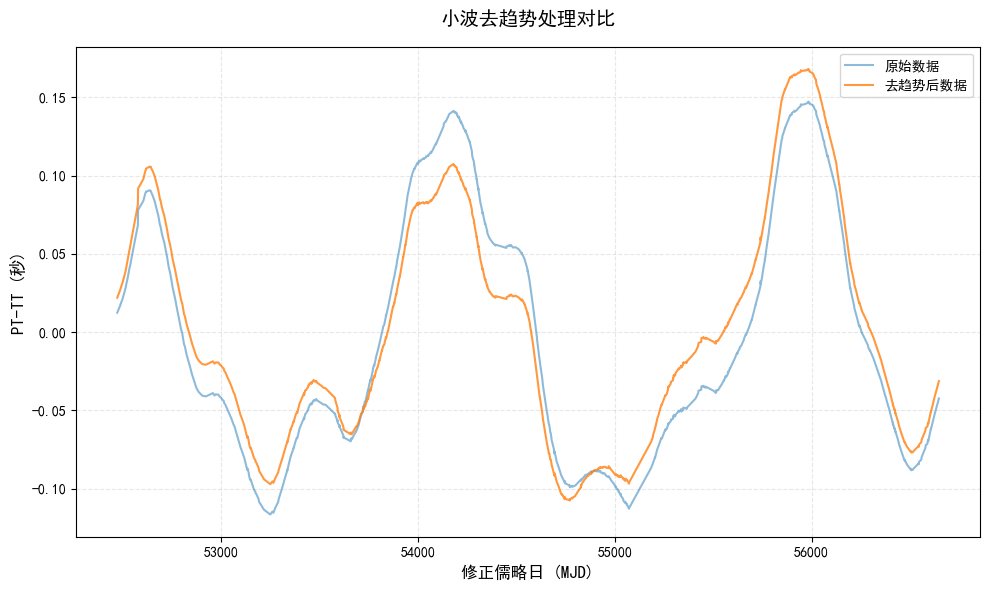

In [17]:
# ——————————————————————————
# 第二部分：小波去趋势处理
# ——————————————————————————

# 使用小波变换进行数据去趋势
def detrend_wavelet(data, wavelet='db8', level=8):
    # 确保数据长度满足小波变换要求
    coeffs = pywt.wavedec(data, wavelet, level=level)
    coeffs[0][:] = 0  # 移除最低频成分（趋势）
    detrended = pywt.waverec(coeffs, wavelet)
    # 确保输出长度与输入相同
    return detrended[:len(data)]

# 应用小波去趋势
detrended_residuals = detrend_wavelet(residuals)

# 可视化去趋势结果
plt.figure(figsize=(10, 6), facecolor='white')
plt.plot(time, residuals, label='原始数据', alpha=0.5)
plt.plot(time[:len(detrended_residuals)], detrended_residuals, label='去趋势后数据', alpha=0.8)
plt.xlabel('修正儒略日 (MJD)', fontsize=12)
plt.ylabel('PT-TT (秒)', fontsize=12)
plt.title('小波去趋势处理对比', fontsize=14, pad=15)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(frameon=True, fontsize=10)
plt.tight_layout()
plt.show()


In [1]:

# ——————————————————————————
# 第五部分：结果可视化与评估
# ——————————————————————————

# 计算最终拟合结果
psd_fitted = complex_power_spectral_density(frequencies, *params)

# 绘制拟合结果
plt.figure(figsize=(10, 6))
plt.loglog(frequencies, psd_values, label="原始PSD", color="blue", alpha=0.6)
plt.loglog(frequencies, psd_fitted, label="拟合PSD", color="red", linestyle="--")
plt.xlabel("频率 (Hz)")
plt.ylabel("功率谱密度")
plt.title("改进的复合噪声模型拟合")
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

# 计算改进的R²
def calculate_improved_r_squared(y_true, y_pred):
    """计算加权对数空间中的R²值"""
    y_true_log = np.log10(y_true)
    y_pred_log = np.log10(y_pred)
    weights = 1 / np.log10(frequencies)  # 对低频部分给予更高权重
    weights = weights / np.sum(weights)
    
    residuals = (y_true_log - y_pred_log) * weights
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum(((y_true_log - np.mean(y_true_log)) * weights)**2)
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared

# 计算并输出改进后的R²
r_squared = calculate_improved_r_squared(psd_values, psd_fitted)
print(f"\n改进后的模型拟合结果：")
print(f"P0 = {params[0]:.2e}, fc1 = {params[1]:.2e}, q1 = {params[2]:.2f}")
print(f"fc2 = {params[3]:.2e}, q2 = {params[4]:.2f}")
print(f"alpha = {params[5]:.2e}, beta = {params[6]:.2f}")
print(f"模型拟合度 (R²): {r_squared:.4f}")

if r_squared >= 0.95:
    print("模型拟合度达到95%以上，符合要求。")
else:
    print("模型拟合度未达到95%，需要继续优化。")

NameError: name 'complex_power_spectral_density' is not defined